In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, accuracy_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def read_atp_data(years):
    """
    Reads ATP matches data from CSV files for the specified years.

    Args:
        years (list or range): A list or range of years to read data for.

    Returns:
        pandas.DataFrame: A combined DataFrame containing all the data from the specified years.
    """
    data = []
    for year in years:
        # Check for Excel file with .xls extension
        xls_file_path = f"{year}.xls"
        if os.path.exists(xls_file_path):
            df = pd.read_excel(xls_file_path)
            data.append(df)
            continue

        # Check for Excel file with .xlsx extension
        xlsx_file_path = f"{year}.xlsx"
        if os.path.exists(xlsx_file_path):
            df = pd.read_excel(xlsx_file_path)
            data.append(df)
            continue

        # If the file is not found
        print(f"File not found: {xls_file_path}, or {xlsx_file_path}")

    if data:
        combined_data = pd.concat(data, ignore_index=True)
        return combined_data
    else:
        return None

In [3]:
def compute_point_difference(df):
    df.rename(columns={
        'Winner': 'winner_name',
        'Loser': 'loser_name',
        'WRank': 'winner_rank',
        'LRank': 'loser_rank',
        'WPts': 'winner_rank_points',
        'LPts': 'loser_rank_points',
        'Date': 'tourney_date'
    }, inplace=True)
    df["loser_rank"] = df["loser_rank"].fillna(100000)
    df["winner_rank"] = df["winner_rank"].fillna(100000)

    df["higher_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["winner_rank_points"], df["loser_rank_points"])
    df["lower_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["loser_rank_points"], df["winner_rank_points"])
    
    df["point_difference"] = df["higher_rank_points"] - df["lower_rank_points"]
    df["higher_rank_won"] = df["winner_rank"] < df["loser_rank"]
    df.dropna(inplace=True, subset=["point_difference"])
    df = df[~df['Comment'].isin(['Retired', 'Walkover'])]
    return df

In [4]:
def accuracy(pred, actual):
    return np.mean(pred == actual)

def calibration(prob, actual):
    return np.mean(prob) / np.mean(actual)

def log_loss(prob, actual):
    return -np.mean(actual * np.log(prob) + (1 - actual) * np.log(1 - prob))

def validation_stats_calculate(df):
    acc = accuracy(df["pred"], df["actual"])
    calib = calibration(df["prob"], df["actual"])
    ll = log_loss(df["prob"], df["actual"])
    return {"accuracy": acc, "calibration": calib, "log_loss": ll}

def validation_stats(df, model_name=None):
    stats = validation_stats_calculate(df)
    print(f"{model_name}")
    print(f" - Accuracy: {stats['accuracy']:.4f}")
    print(f" - Calibration: {stats['calibration']:.4f}")
    print(f" - Log Loss: {stats['log_loss']:.4f}")
    print("--------------------------------------")
    return stats

def make_predictions(df):
    df["pred"] = df["prob"] > 0.5
    return df

In [5]:
def get_elo_prob(elo1, elo2):
    return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

In [6]:
def update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches)
    k_loser = k_func(loser_matches)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

In [7]:
def implement_elo(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_elo_before_game"] = winner_elo
        df_elo.at[index, "loser_elo_before_game"] = loser_elo

    return df_elo, elo_ratings

In [8]:
def get_bcm_probabilities(df):
    def implied_prob(row, bookie):
        alpha_w = row[f"{bookie}W"]
        beta_l = row[f"{bookie}L"]
        return beta_l / (alpha_w + beta_l)
    
    bookmakers = ["B365", "PS"]
    implied_probs_winner = []
    implied_probs_loser = []
    
    for _, row in df.iterrows():
        probs_winner = [implied_prob(row, bookie) for bookie in bookmakers]
        probs_loser = [1 - prob for prob in probs_winner]
        implied_probs_winner.append(probs_winner)
        implied_probs_loser.append(probs_loser)
    
    df["implied_prob_winner"] = np.mean(implied_probs_winner, axis=1)
    df["implied_prob_loser"] = np.mean(implied_probs_loser, axis=1)

    df["implied_prob_winner_norm"] = df["implied_prob_winner"] / (df["implied_prob_winner"] + df["implied_prob_loser"])
    df["implied_prob_loser_norm"] = df["implied_prob_loser"] / (df["implied_prob_winner"] + df["implied_prob_loser"])

    df["bcm_prob"] = df["implied_prob_winner_norm"]
    return df

In [9]:
years = range(2013, 2023)  # range of years from 2013 to 2023
df = read_atp_data(years)
df = compute_point_difference(df)
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d')
df_train = df[df["tourney_date"].dt.year < 2022].copy().reset_index(drop=True)
df_test = df[df["tourney_date"].dt.year == 2022].copy().reset_index(drop=True)

/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
# Naive Model
naive_prob = df_train["higher_rank_won"].mean()
naive_prob_arr = np.repeat(naive_prob, df_test.shape[0])
df_naive = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": naive_prob_arr})
df_naive = make_predictions(df_naive)
validation_stats(df_naive, model_name="Naive Model")

# Logistic Regression Model
X_train = df_train[["point_difference"]]
y_train = df_train["higher_rank_won"]

logistic_model = LogisticRegression(fit_intercept=False)
logistic_model.fit(X_train, y_train)

logistic_prob_arr = logistic_model.predict_proba(df_test[["point_difference"]])[:, 1]
df_logistic = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": logistic_prob_arr})
df_logistic = make_predictions(df_logistic)
validation_stats(df_logistic, model_name="Logistic Regression")

Naive Model
 - Accuracy: 0.6428
 - Calibration: 1.0172
 - Log Loss: 0.6520
--------------------------------------
Logistic Regression
 - Accuracy: 0.6428
 - Calibration: 0.9533
 - Log Loss: 0.6401
--------------------------------------


{'accuracy': 0.6428290766208251,
 'calibration': 0.9532971043486245,
 'log_loss': 0.6400686572940905}

In [11]:
def k_fixed(matches_played, k=32):
    return k
# ELO Model with fixed K-factor
df_elo_train_fixed, elo_ratings_fixed = implement_elo(df_train, k_fixed)
prob_higher_rank_fixed = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_fixed.get(winner, 1500)
    loser_elo = elo_ratings_fixed.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_fixed.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
    elo_ratings_fixed[winner] = winner_new_elo
    elo_ratings_fixed[loser] = loser_new_elo

df_k_factor_test = df_test.copy()
df_k_factor_test["prob"] = prob_higher_rank_fixed
df_k_factor_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_k_factor_test = make_predictions(df_k_factor_test)
validation_stats(df_k_factor_test, model_name="ELO Model (K-factor)")

ELO Model (K-factor)
 - Accuracy: 0.6472
 - Calibration: 0.9953
 - Log Loss: 0.6165
--------------------------------------


{'accuracy': 0.6471512770137524,
 'calibration': 0.9952840880240154,
 'log_loss': 0.616503267644809}

In [12]:
# Define the search space for hyperparameters
space  = [
    Real(1, 50, name='k')
]

@use_named_args(space)
def objective(k):
    def k_fixed(matches_played, k=k):
        return k

    df_elo_train, elo_ratings = implement_elo(df_train, k_fixed)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameter: k=%.2f" % res_gp.x[0])

Best score=0.6527
Best parameter: k=48.17


In [13]:
def k_fixed(matches_played, k=48.17):
    return k
# ELO Model with fixed K-factor
df_elo_train_fixed, elo_ratings_fixed = implement_elo(df_train, k_fixed)
prob_higher_rank_fixed = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_fixed.get(winner, 1500)
    loser_elo = elo_ratings_fixed.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_fixed.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_fixed, winner_matches, loser_matches)
    elo_ratings_fixed[winner] = winner_new_elo
    elo_ratings_fixed[loser] = loser_new_elo

df_k_factor_test = df_test.copy()
df_k_factor_test["prob"] = prob_higher_rank_fixed
df_k_factor_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_k_factor_test = make_predictions(df_k_factor_test)
validation_stats(df_k_factor_test, model_name="ELO Model (K-factor)")

ELO Model (K-factor)
 - Accuracy: 0.6527
 - Calibration: 1.0110
 - Log Loss: 0.6215
--------------------------------------


{'accuracy': 0.6526522593320235,
 'calibration': 1.010982188955841,
 'log_loss': 0.6215398602476306}

In [14]:
def k_538(matches_played, delta=100, nu=5, sigma=0.1):
    return delta / (matches_played + nu) ** sigma
# ELO Model with k_538
df_elo_train_538, elo_ratings_538 = implement_elo(df_train, k_538)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538)")

ELO Model (k_538)
 - Accuracy: 0.6479
 - Calibration: 1.0243
 - Log Loss: 0.6267
--------------------------------------


{'accuracy': 0.6479371316306484,
 'calibration': 1.024320144669537,
 'log_loss': 0.6266581203826803}

In [15]:

# Define the search space for hyperparameters
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538(matches_played, delta=delta, nu=nu, sigma=sigma):
        return delta / (matches_played + nu) ** sigma
    
    df_elo_train, elo_ratings = implement_elo(df_train, k_538)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameters: delta=%d, nu=%d, sigma=%.2f" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Best score=0.6487
Best parameters: delta=196, nu=7, sigma=0.10


In [16]:
def k_538(matches_played, delta=196, nu=7, sigma=0.10):
    return delta / (matches_played + nu) ** sigma
# ELO Model with k_538
df_elo_train_538, elo_ratings_538 = implement_elo(df_train, k_538)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_538, winner_matches, loser_matches)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538)")

ELO Model (k_538)
 - Accuracy: 0.6487
 - Calibration: 1.0385
 - Log Loss: 0.6575
--------------------------------------


{'accuracy': 0.6487229862475442,
 'calibration': 1.0385369353406442,
 'log_loss': 0.6575451900239043}

In [17]:
# Implement BCM model on test data
df_test = get_bcm_probabilities(df_test)

df_bcm = df_test.copy()
df_bcm.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_bcm["prob"] = df_bcm["bcm_prob"]
df_bcm = make_predictions(df_bcm)
validation_stats(df_bcm, model_name="Bookmakers Consensus Model (BCM)")

Bookmakers Consensus Model (BCM)
 - Accuracy: 0.7969
 - Calibration: 0.9292
 - Log Loss: 0.4886
--------------------------------------


{'accuracy': 0.7968565815324165,
 'calibration': 0.9291914575446384,
 'log_loss': 0.4886259540948213}

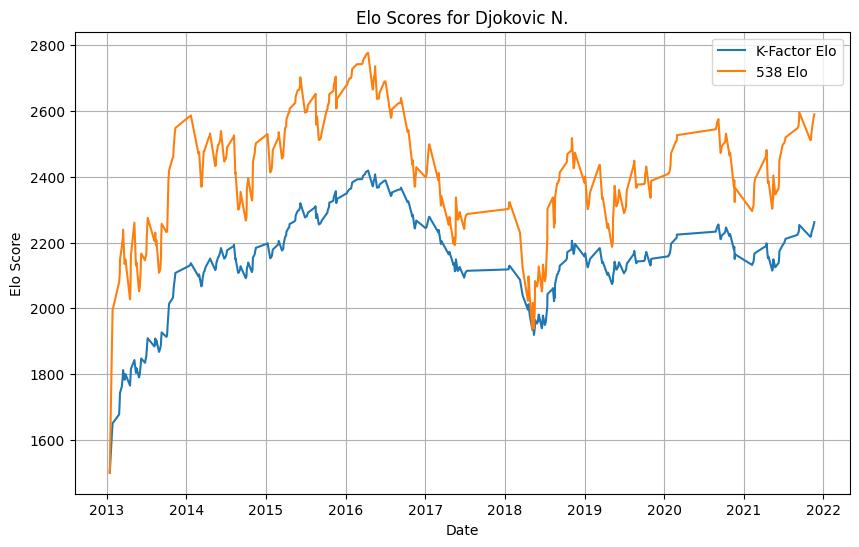

In [18]:
def get_individual_data(df, player_name):
    player_mask = (df["winner_name"] == player_name) | (df["loser_name"] == player_name)
    df_player = df[player_mask].copy()
    player_won = df_player["winner_name"] == player_name

    df_player["elo_before_game"] = np.where(player_won, df_player["winner_elo_before_game"], df_player["loser_elo_before_game"])
    df_player = df_player.sort_values("tourney_date")
    return df_player

def plot_elo_scores(player_name, df_player_k_factor, df_player_538):
    plt.figure(figsize=(10, 6))
    plt.plot(df_player_k_factor["tourney_date"], df_player_k_factor["elo_before_game"], label="K-Factor Elo")
    plt.plot(df_player_538["tourney_date"], df_player_538["elo_before_game"], label="538 Elo")
    plt.title(f"Elo Scores for {player_name}")
    plt.xlabel("Date")
    plt.ylabel("Elo Score")
    plt.legend()
    plt.grid(True)
    plt.show()

player_name = "Djokovic N."
df_player_k_factor = get_individual_data(df_elo_train_fixed, player_name)
df_player_538 = get_individual_data(df_elo_train_538, player_name)

plot_elo_scores(player_name, df_player_k_factor, df_player_538)

In [19]:
def margin_of_victory(num_sets_won_winner, num_sets_won_loser):
    return num_sets_won_winner - num_sets_won_loser

def k_margin(matches_played, margin, base_k=32, margin_factor=10):
    # Adjust the K-factor based on the margin of victory
    return base_k + margin_factor * margin

def update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches, margin)
    k_loser = k_func(loser_matches, margin)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

def implement_elo_with_margin(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        num_sets_won_winner = row["Wsets"]
        num_sets_won_loser = row["Lsets"]
        margin = margin_of_victory(num_sets_won_winner, num_sets_won_loser)

        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_elo_before_game"] = winner_elo
        df_elo.at[index, "loser_elo_before_game"] = loser_elo

    return df_elo, elo_ratings

In [20]:
# Implement the new ELO model with margin adjustment
def k_margin_func(matches_played, margin, k=32, margin_factor=17):
    return k + margin_factor * margin

# ELO Model with margin adjustment
df_elo_train_margin, elo_ratings_margin = implement_elo_with_margin(df_train, k_margin_func)
prob_higher_rank_margin = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    num_sets_won_winner = row["Wsets"]
    num_sets_won_loser = row["Lsets"]
    margin = margin_of_victory(num_sets_won_winner, num_sets_won_loser)

    winner_elo = elo_ratings_margin.get(winner, 1500)
    loser_elo = elo_ratings_margin.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i

    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_margin.append(prob if row["higher_rank_won"] else 1 - prob)

    winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_margin_func, winner_matches, loser_matches, margin)
    elo_ratings_margin[winner] = winner_new_elo
    elo_ratings_margin[loser] = loser_new_elo

df_margin_test = df_test.copy()
df_margin_test["prob"] = prob_higher_rank_margin
df_margin_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_margin_test = make_predictions(df_margin_test)
validation_stats(df_margin_test, model_name="ELO Model (Margin Adjustment)")

ELO Model (Margin Adjustment)
 - Accuracy: 0.6487
 - Calibration: 1.0265
 - Log Loss: 0.6274
--------------------------------------


{'accuracy': 0.6487229862475442,
 'calibration': 1.0264992433170457,
 'log_loss': 0.6274064355221685}

In [21]:
# Define the search space for hyperparameters
space  = [
    Real(1, 50, name='k'),
    Real(5, 50, name='margin_factor')
]
@use_named_args(space)
def objective(k, margin_factor):
    
    def k_538_with_margin(matches_played, margin, k=k, margin_factor=margin_factor):
        return k + margin_factor * margin  # Use margin_factor here

    df_elo_train, elo_ratings = implement_elo_with_margin(df_train, k_538_with_margin)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        margin = row["Wsets"] - row["Lsets"]
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_538_with_margin, winner_matches, loser_matches, margin)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameters: k=%.2f, margin_factor=%.2f" % (res_gp.x[0], res_gp.x[1]))

Best score=0.6554
Best parameters: k=1.00, margin_factor=13.38


In [22]:
# Implement the new ELO model with margin adjustment
def k_margin_func(matches_played, margin, k=1, margin_factor=13.38):
    return k + margin_factor * margin

# ELO Model with margin adjustment
df_elo_train_margin, elo_ratings_margin = implement_elo_with_margin(df_train, k_margin_func)
prob_higher_rank_margin = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    num_sets_won_winner = row["Wsets"]
    num_sets_won_loser = row["Lsets"]
    margin = margin_of_victory(num_sets_won_winner, num_sets_won_loser)

    winner_elo = elo_ratings_margin.get(winner, 1500)
    loser_elo = elo_ratings_margin.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i

    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_margin.append(prob if row["higher_rank_won"] else 1 - prob)

    winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_margin_func, winner_matches, loser_matches, margin)
    elo_ratings_margin[winner] = winner_new_elo
    elo_ratings_margin[loser] = loser_new_elo

df_margin_test = df_test.copy()
df_margin_test["prob"] = prob_higher_rank_margin
df_margin_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_margin_test = make_predictions(df_margin_test)
validation_stats(df_margin_test, model_name="ELO Model (Margin Adjustment)")

ELO Model (Margin Adjustment)
 - Accuracy: 0.6558
 - Calibration: 0.9978
 - Log Loss: 0.6162
--------------------------------------


{'accuracy': 0.6557956777996071,
 'calibration': 0.9977790201912118,
 'log_loss': 0.6161563274166015}

In [23]:
def k_538_with_margin(matches_played, margin, delta=100, nu=5, sigma=0.1):
    return (delta * margin) / (matches_played + nu) ** sigma

# ELO Model with k_538 including margin of victory
df_elo_train_538, elo_ratings_538 = implement_elo_with_margin(df_train, k_538_with_margin)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    margin = row["Wsets"] - row["Lsets"]
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_538_with_margin, winner_matches, loser_matches, margin)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538 with Margin of Victory)")

ELO Model (k_538 with Margin of Victory)
 - Accuracy: 0.6499
 - Calibration: 1.0527
 - Log Loss: 0.6561
--------------------------------------


{'accuracy': 0.649901768172888,
 'calibration': 1.0527401749534975,
 'log_loss': 0.6560747833356303}

In [24]:

# Define the search space for hyperparameters
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538_with_margin(matches_played, margin, delta=delta, nu=nu, sigma=sigma):
        return (delta * margin) / (matches_played + nu) ** sigma
    
    df_elo_train, elo_ratings = implement_elo_with_margin(df_train, k_538_with_margin)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        margin = row["Wsets"] - row["Lsets"]
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_538_with_margin, winner_matches, loser_matches, margin)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    
    acc = accuracy_score(df_test_copy["actual"], df_test_copy["pred"])
    
    return -acc  # Minimize the negative accuracy

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % -res_gp.fun)
print("Best parameters: delta=%d, nu=%d, sigma=%.2f" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Best score=0.6582
Best parameters: delta=100, nu=5, sigma=0.27


In [25]:
def k_538_with_margin(matches_played, margin, delta=100, nu=5, sigma=0.27):
    return (delta * margin) / (matches_played + nu) ** sigma

# ELO Model with k_538 including margin of victory
df_elo_train_538, elo_ratings_538 = implement_elo_with_margin(df_train, k_538_with_margin)
prob_higher_rank_538 = []

# Update Elo ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_elo = elo_ratings_538.get(winner, 1500)
    loser_elo = elo_ratings_538.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    margin = row["Wsets"] - row["Lsets"]
    prob = get_elo_prob(winner_elo, loser_elo)
    prob_higher_rank_538.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update Elo ratings based on the match result
    winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_538_with_margin, winner_matches, loser_matches, margin)
    elo_ratings_538[winner] = winner_new_elo
    elo_ratings_538[loser] = loser_new_elo

df_538_test = df_test.copy()
df_538_test["prob"] = prob_higher_rank_538
df_538_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_538_test = make_predictions(df_538_test)
validation_stats(df_538_test, model_name="ELO Model (k_538 with Margin of Victory)")

ELO Model (k_538 with Margin of Victory)
 - Accuracy: 0.6566
 - Calibration: 1.0401
 - Log Loss: 0.6280
--------------------------------------


{'accuracy': 0.656581532416503,
 'calibration': 1.0400603237701807,
 'log_loss': 0.6279530543478306}

In [26]:
from trueskill import TrueSkill, Rating

def get_trueskill_prob(rating1, rating2):
    delta_mu = rating1.mu - rating2.mu
    sum_sigma = rating1.sigma ** 2 + rating2.sigma ** 2
    return 1 / (1 + 10 ** (-delta_mu / (2 * sum_sigma ** 0.5)))

def implement_trueskill(df):
    trueskill_env = TrueSkill(mu=25, sigma=25/3, draw_probability=0)
    trueskill_ratings = {}
    df_trueskill = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
        loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())

        winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)

        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

        df_trueskill.at[index, "trueskill_prob"] = get_trueskill_prob(winner_new_rating, loser_new_rating)
        df_trueskill.at[index, "winner_trueskill_before_game"] = winner_rating.mu - 3 * winner_rating.sigma
        df_trueskill.at[index, "loser_trueskill_before_game"] = loser_rating.mu - 3 * loser_rating.sigma

    return df_trueskill, trueskill_ratings

# TrueSkill Model
trueskill_env = TrueSkill(mu=25, sigma=25/3, draw_probability=0)
df_trueskill_train, trueskill_ratings = implement_trueskill(df_train)
prob_higher_rank_trueskill = []

# Update TrueSkill ratings dynamically during testing
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
    loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())
    prob = get_trueskill_prob(winner_rating, loser_rating)
    prob_higher_rank_trueskill.append(prob if row["higher_rank_won"] else 1 - prob)
    # Update TrueSkill ratings based on the match result
    winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)
    trueskill_ratings[winner] = winner_new_rating
    trueskill_ratings[loser] = loser_new_rating

df_trueskill_test = df_test.copy()
df_trueskill_test["prob"] = prob_higher_rank_trueskill
df_trueskill_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_trueskill_test = make_predictions(df_trueskill_test)
validation_stats(df_trueskill_test, model_name="TrueSkill Model")

TrueSkill Model
 - Accuracy: 0.6369
 - Calibration: 1.0950
 - Log Loss: 0.7918
--------------------------------------


{'accuracy': 0.6369351669941061,
 'calibration': 1.0949944330791979,
 'log_loss': 0.7917844438106166}

In [27]:
def objective(params):
    mu, sigma = params
    trueskill_env = TrueSkill(mu=mu, sigma=sigma, draw_probability=0)
    df_trueskill_train, trueskill_ratings = implement_trueskill(df_train)
    prob_higher_rank_trueskill = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
        loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())
        prob = get_trueskill_prob(winner_rating, loser_rating)
        prob_higher_rank_trueskill.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)
        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

    df_trueskill_test = df_test.copy()
    df_trueskill_test["prob"] = prob_higher_rank_trueskill
    df_trueskill_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_trueskill_test = make_predictions(df_trueskill_test)
    stats = validation_stats_calculate(df_trueskill_test)
    return -stats["accuracy"]

space = [
    Real(10, 50, name='mu'),
    Real(1, 10, name='sigma')
]

result = gp_minimize(objective, space, n_calls=50, random_state=42)
print("Best accuracy: %.4f" % -result.fun)
print("Best hyperparameters: mu=%.2f, sigma=%.2f" % (result.x[0], result.x[1]))

Best accuracy: 0.6420
Best hyperparameters: mu=26.23, sigma=4.68


In [30]:
import math

# Các hằng số trong mô hình Glicko
Q = math.log(10) / 400  # Q = ln(10)/400
INITIAL_RD = 350  # Giá trị RD ban đầu

def glicko_rating_update(rating, rd, opponent_ratings, scores, weights=None):
    """
    Cập nhật xếp hạng và độ tin cậy (RD) cho một người chơi sau một loạt trận đấu.
    
    Args:
        rating (float): Xếp hạng hiện tại của người chơi.
        rd (float): Độ tin cậy hiện tại của người chơi.
        opponent_ratings (list): Danh sách xếp hạng của các đối thủ.
        scores (list): Danh sách kết quả trận đấu tương ứng (1 nếu thắng, 0 nếu thua).
        weights (list, optional): Danh sách trọng số tương ứng cho các trận đấu (mặc định là None).
    
    Returns:
        tuple: Cặp (xếp hạng mới, độ tin cậy mới) sau khi cập nhật.
    """
    if weights is None:
        weights = [1] * len(opponent_ratings)
    
    # Tính toán g(RD)
    g_rd = 1 / math.sqrt(1 + 3 * (rd ** 2) / (math.pi ** 2))
    
    # Tính toán E(score) dựa trên xếp hạng hiện tại và xếp hạng đối thủ
    expected_scores = [1 / (1 + 10 ** (-g_rd * (rating - opp_rating) / 400)) for opp_rating in opponent_ratings]
    
    # Cập nhật xếp hạng mới
    new_rating = rating
    for opp_rating, score, weight in zip(opponent_ratings, scores, weights):
        new_rating += weight * g_rd * (score - 1 / (1 + 10 ** (-g_rd * (rating - opp_rating) / 400)))
    
    # Cập nhật độ tin cậy mới
    sum_squared_weights = sum(w ** 2 for w in weights)
    new_rd = math.sqrt(sum_squared_weights / (sum_squared_weights + math.pi ** 2 / 6 - sum_squared_weights / 4) * rd ** 2)
    
    return new_rating, new_rd

def implement_glicko(df, rd=INITIAL_RD):
    glicko_ratings = {}
    matches_played = {}
    df_glicko = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = glicko_ratings.get(winner, 1500)
        loser_rating = glicko_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        # Cập nhật xếp hạng và độ tin cậy cho người thắng
        new_winner_rating, new_winner_rd = glicko_rating_update(winner_rating, rd, [loser_rating], [1])
        glicko_ratings[winner] = new_winner_rating
        matches_played[winner] = winner_matches + 1

        # Cập nhật xếp hạng và độ tin cậy cho người thua
        new_loser_rating, new_loser_rd = glicko_rating_update(loser_rating, rd, [winner_rating], [0])
        glicko_ratings[loser] = new_loser_rating
        matches_played[loser] = loser_matches + 1

        df_glicko.at[index, "glicko_prob"] = 1 / (1 + 10 ** (-new_winner_rating / 400 + new_loser_rating / 400))
        df_glicko.at[index, "winner_glicko_before_game"] = winner_rating
        df_glicko.at[index, "loser_glicko_before_game"] = loser_rating

    return df_glicko, glicko_ratings
# Áp dụng mô hình Glicko cho tập huấn luyện
df_glicko_train, glicko_ratings = implement_glicko(df_train, rd=INITIAL_RD)

# Dự đoán xác suất cho tập kiểm tra
prob_higher_rank_glicko = []

# Cập nhật xếp hạng và độ tin cậy Glicko trong quá trình kiểm tra
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_rating = glicko_ratings.get(winner, 1500)
    loser_rating = glicko_ratings.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i

    # Cập nhật xếp hạng và độ tin cậy cho người thắng
    new_winner_rating, new_winner_rd = glicko_rating_update(winner_rating, INITIAL_RD, [loser_rating], [1])
    glicko_ratings[winner] = new_winner_rating

    # Cập nhật xếp hạng và độ tin cậy cho người thua
    new_loser_rating, new_loser_rd = glicko_rating_update(loser_rating, INITIAL_RD, [winner_rating], [0])
    glicko_ratings[loser] = new_loser_rating

    prob = 1 / (1 + 10 ** (-new_winner_rating / 400 + new_loser_rating / 400))
    prob_higher_rank_glicko.append(prob if row["higher_rank_won"] else 1 - prob)

df_glicko_test = df_test.copy()
df_glicko_test["prob"] = prob_higher_rank_glicko
df_glicko_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_glicko_test = make_predictions(df_glicko_test)
validation_stats(df_glicko_test, model_name="Glicko Model")

Glicko Model
 - Accuracy: 0.6448
 - Calibration: 0.7780
 - Log Loss: 0.6930
--------------------------------------


{'accuracy': 0.6447937131630649,
 'calibration': 0.7779892683190797,
 'log_loss': 0.6929618012890324}

In [36]:
import math
import datetime

# Các hằng số trong mô hình Glicko
Q = math.log(10) / 400  # Q = ln(10)/400
INITIAL_RD = 350  # Giá trị RD ban đầu
RD_DECAY_RATE = 0.05  # Tỷ lệ suy giảm RD theo thời gian

def glicko_rating_update(rating, rd, opponent_ratings, scores, weights=None):
    """
    Cập nhật xếp hạng và độ tin cậy (RD) cho một người chơi sau một loạt trận đấu.
    
    Args:
        rating (float): Xếp hạng hiện tại của người chơi.
        rd (float): Độ tin cậy hiện tại của người chơi.
        opponent_ratings (list): Danh sách xếp hạng của các đối thủ.
        scores (list): Danh sách kết quả trận đấu tương ứng (1 nếu thắng, 0 nếu thua).
        weights (list, optional): Danh sách trọng số tương ứng cho các trận đấu (mặc định là None).
    
    Returns:
        tuple: Cặp (xếp hạng mới, độ tin cậy mới) sau khi cập nhật.
    """
    if weights is None:
        weights = [1] * len(opponent_ratings)
    
    # Tính toán g(RD)
    g_rd = 1 / math.sqrt(1 + 3 * (rd ** 2) / (math.pi ** 2))
    
    # Tính toán E(score) dựa trên xếp hạng hiện tại và xếp hạng đối thủ
    expected_scores = [1 / (1 + 10 ** (-g_rd * (rating - opp_rating) / 400)) for opp_rating in opponent_ratings]
    
    # Cập nhật xếp hạng mới
    new_rating = rating
    for opp_rating, score, weight in zip(opponent_ratings, scores, weights):
        new_rating += weight * g_rd * (score - 1 / (1 + 10 ** (-g_rd * (rating - opp_rating) / 400)))
    
    # Cập nhật độ tin cậy mới
    sum_squared_weights = sum(w ** 2 for w in weights)
    new_rd = math.sqrt(sum_squared_weights / (sum_squared_weights + math.pi ** 2 / 6 - sum_squared_weights / 4) * rd ** 2)
    
    return new_rating, new_rd

def update_rd(rd, last_match_date, current_date):
    """
    Cập nhật Rating Deviation (RD) dựa trên khoảng thời gian giữa trận đấu cuối cùng và trận đấu hiện tại.
    """
    days_since_last_match = (current_date - last_match_date).days
    return min(rd + RD_DECAY_RATE * days_since_last_match, 350)

def implement_glicko(df):
    glicko_ratings = {}
    last_match_dates = {}
    df_glicko = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = glicko_ratings.get(winner, 1500)
        loser_rating = glicko_ratings.get(loser, 1500)
        winner_last_match_date = last_match_dates.get(winner, datetime.date(1970, 1, 1))
        loser_last_match_date = last_match_dates.get(loser, datetime.date(1970, 1, 1))
        current_date = row["tourney_date"].date()

        # Cập nhật RD cho người thắng và người thua
        winner_rd = update_rd(INITIAL_RD, winner_last_match_date, current_date)
        loser_rd = update_rd(INITIAL_RD, loser_last_match_date, current_date)

        # Cập nhật xếp hạng và RD cho người thắng
        new_winner_rating, new_winner_rd = glicko_rating_update(winner_rating, winner_rd, [loser_rating], [1])
        glicko_ratings[winner] = new_winner_rating
        last_match_dates[winner] = current_date

        # Cập nhật xếp hạng và RD cho người thua
        new_loser_rating, new_loser_rd = glicko_rating_update(loser_rating, loser_rd, [winner_rating], [0])
        glicko_ratings[loser] = new_loser_rating
        last_match_dates[loser] = current_date

        df_glicko.at[index, "glicko_prob"] = 1 / (1 + 10 ** (-new_winner_rating / 400 + new_loser_rating / 400))

    return df_glicko, glicko_ratings, last_match_dates

# Áp dụng mô hình Glicko cho tập huấn luyện
df_glicko_train, glicko_ratings, last_match_dates = implement_glicko(df_train)

# Dự đoán xác suất cho tập kiểm tra
prob_higher_rank_glicko = []

# Cập nhật xếp hạng và độ tin cậy Glicko trong quá trình kiểm tra
for i, row in df_test.iterrows():
    winner = row["winner_name"]
    loser = row["loser_name"]
    winner_rating = glicko_ratings.get(winner, 1500)
    loser_rating = glicko_ratings.get(loser, 1500)
    winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
    loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
    current_date = row["tourney_date"].date()

    # Cập nhật RD cho người thắng và người thua
    winner_last_match_date = last_match_dates.get(winner, datetime.date(1970, 1, 1))
    loser_last_match_date = last_match_dates.get(loser, datetime.date(1970, 1, 1))
    winner_rd = update_rd(INITIAL_RD, winner_last_match_date, current_date)
    loser_rd = update_rd(INITIAL_RD, loser_last_match_date, current_date)

    # Cập nhật xếp hạng và độ tin cậy cho người thắng
    new_winner_rating, new_winner_rd = glicko_rating_update(winner_rating, winner_rd, [loser_rating], [1])
    glicko_ratings[winner] = new_winner_rating

    # Cập nhật xếp hạng và độ tin cậy cho người thua
    new_loser_rating, new_loser_rd = glicko_rating_update(loser_rating, loser_rd, [winner_rating], [0])
    glicko_ratings[loser] = new_loser_rating

    # Cập nhật ngày diễn ra trận đấu cuối cùng cho người thắng và người thua
    last_match_dates[winner] = current_date
    last_match_dates[loser] = current_date

    prob = 1 / (1 + 10 ** (-new_winner_rating / 400 + new_loser_rating / 400))
    prob_higher_rank_glicko.append(prob if row["higher_rank_won"] else 1 - prob)

df_glicko_test = df_test.copy()
df_glicko_test["prob"] = prob_higher_rank_glicko
df_glicko_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_glicko_test = make_predictions(df_glicko_test)
validation_stats(df_glicko_test, model_name="Glicko Model")

Glicko Model
 - Accuracy: 0.6448
 - Calibration: 0.7780
 - Log Loss: 0.6930
--------------------------------------


{'accuracy': 0.6447937131630649,
 'calibration': 0.7779892669128765,
 'log_loss': 0.6929618021898953}